Import  Modules

In [53]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import face_recognition
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

Load and display the image using PIL and matplotlib

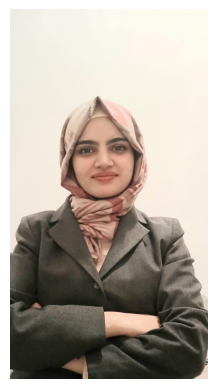

In [67]:
image_path = 'person.jpeg'
image = Image.open(image_path) 
plt.axis('off')
plt.imshow(image)
plt.show()



Define a function for highlighting facial points on an image

In [68]:
def highlight_facial_points(image_path):
    ## load the image using openCV with bgr as default
    image_bgr = cv2.imread(image_path) 
    # convert the image to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) 
    
    # detects faces in the image 
    face_locations = face_recognition.face_locations(image_rgb, model='cnn') # gives back a tuple of bounding boxes dimensions (top, right, bottom, left)    
    
    for face_location in face_locations:
        # gets the facial landmarks in faces
        landmarks = face_recognition.face_landmarks(image_rgb, face_locations=[face_location])[0] # gives back a dictionary of lists containing landmark type-point (feature-coordinates) pairs
        
         # iterate over the landmark point of each type(feature)
        for landmark_type, landmark_points in landmarks.items():
            for (x,y) in landmark_points:
                cv2.circle(image_rgb, (x,y), 3, (0,255,0), -1)

    # plot the image with the facial landmarks
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


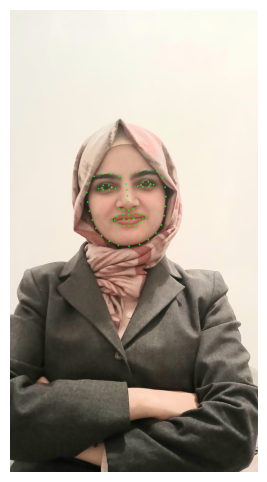

In [69]:
highlight_facial_points(image_path)

Define Eye Aspect Ratio (eye openness) and Mouth Aspect ratio (for yawning)

In [71]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    # vertical distances
    A = distance.euclidean(eye[2], eye[4]) 
    B = distance.euclidean(eye[1], eye[5])
    # horizontal distance
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mouth aspect ratio
def mouth_aspect_ratio(top_lip, bottom_lip):
    # Top lip points
    p2 = top_lip[2]
    p3 = top_lip[3]
    p4 = top_lip[4]

    # Bottom lip points
    p8 = bottom_lip[2]
    p7 = bottom_lip[3]
    p6 = bottom_lip[4]

    # Horizontal points
    p1 = top_lip[0]
    p5 = top_lip[6]

    # Calculate the vertical distances
    A = distance.euclidean(p2, p8)
    B = distance.euclidean(p3, p7)
    C = distance.euclidean(p4, p6)

    # Calculate the horizontal distance
    D = distance.euclidean(p1, p5)

    # Calculate MAR
    mar = (A + B + C) / (3 * D)
    return mar


Define a function to calculate EAR and MAR in a given image frame

In [72]:
def process_image(frame):
    # define thresholds
    EAR_THRESH = 0.25
    MAR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # detect faces in the frame
    face_locations = face_recognition.face_locations(frame_rgb)

    # initiate flags (eye open and mouth closed)
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(frame_rgb, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        top_lip = np.array(landmarks['top_lip'])
        bottom_lip = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0 # averaging for both eyes
        mar = mouth_aspect_ratio(top_lip, bottom_lip)

        # check if eyes are closed
        if ear < EAR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MAR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

Calculating EAR and MAR for the image

In [73]:
# passing the image in image_path to the process_image function
img = cv2.imread(image_path)
process_image(img)

(False, False)

Real Time Drowsiness Detection

In [75]:
#get frames from the webcam
video_cap = cv2.VideoCapture(0) 
count = score = 0

while True:
    success, image = video_cap.read()
    if not success:
        break

    image = cv2.resize(image, (800, 500))

    count += 1
    # process every nth frame
    n = 5
    if count % n == 0:
        eye_flag, mouth_flag = process_image(image)
        # if any flag is true, increment the score
        if eye_flag or mouth_flag:
            score += 1
        else:
            score -= 1
            if score < 0:
                score = 0 #to avoid a negative score

    # write the score values at bottom left of the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_x = 10
    text_y = image.shape[0] - 10
    text = f"Score: {score}"
    cv2.putText(image, text, (text_x, text_y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
  
    if score >= 5:
        text_x = image.shape[1] - 130
        text_y = 40
        text = "Drowsy"
        cv2.putText(image, text, (text_x, text_y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow('drowsiness detection', image)

    # exit if any key is pressed
    if cv2.waitKey(1) & 0xFF != 255:
        break

video_cap.release()
cv2.destroyAllWindows()
